# Convolutional Neural Network - Pattern Recognition in Stock Markets

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import yfinance as yf
# import pandas_datareader as pdr
import csv
import warnings
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical

N = 20

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [22]:
#hide all warnings
#warnings.filterwarnings('ignore')

#show all warnings just once
warnings.filterwarnings(action='once')

In [8]:
from helpers import delete_nans, get_returns, plot_example_returns, tickers, get_data_subsets#, data_loader

/home/cvaz/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Download Data

In [9]:
begin = "2007-01-01"
finish = "2017-01-01"

#data_loader(begin, finish, 'returns.csv')

In [11]:
returns = get_returns('returns.csv', N)

Number of columns with only NaNs: 0
Number of lines with only NaNs: 0
Number of NaNs: 0
shape Dataframe: (2518, 20)


,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN
Date,,,,,,,,,,,,,,,,,,,,
2007-01-03,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-01-04,-0.003961,0.018991,0.0,0.021352,0.022540,0.008158,0.022545,0.013832,0.006464,0.000456,-0.010861,-0.011027,0.003207,-0.021972,0.023622,0.019508,-0.004584,-0.001686,0.002955,0.018727
2007-01-05,-0.006799,0.000000,0.0,-0.014634,-0.013979,-0.005780,-0.004900,-0.004043,-0.022061,-0.028702,-0.008021,0.001312,-0.009299,-0.013934,-0.002064,-0.036116,-0.017446,-0.019664,-0.006629,0.002941
2007-01-08,0.002195,0.003607,0.0,-0.002122,0.014449,-0.000581,-0.004185,-0.012177,0.003427,-0.014071,0.013187,0.000655,-0.003520,-0.001298,-0.003384,0.021092,-0.005114,-0.009523,-0.027435,0.002933
2007-01-09,0.001160,0.008786,0.0,-0.010631,-0.002419,-0.000582,-0.020272,0.009245,0.008537,-0.040914,0.009690,0.003709,0.001178,-0.002166,-0.006414,0.008263,0.005854,0.024956,-0.007624,0.001462


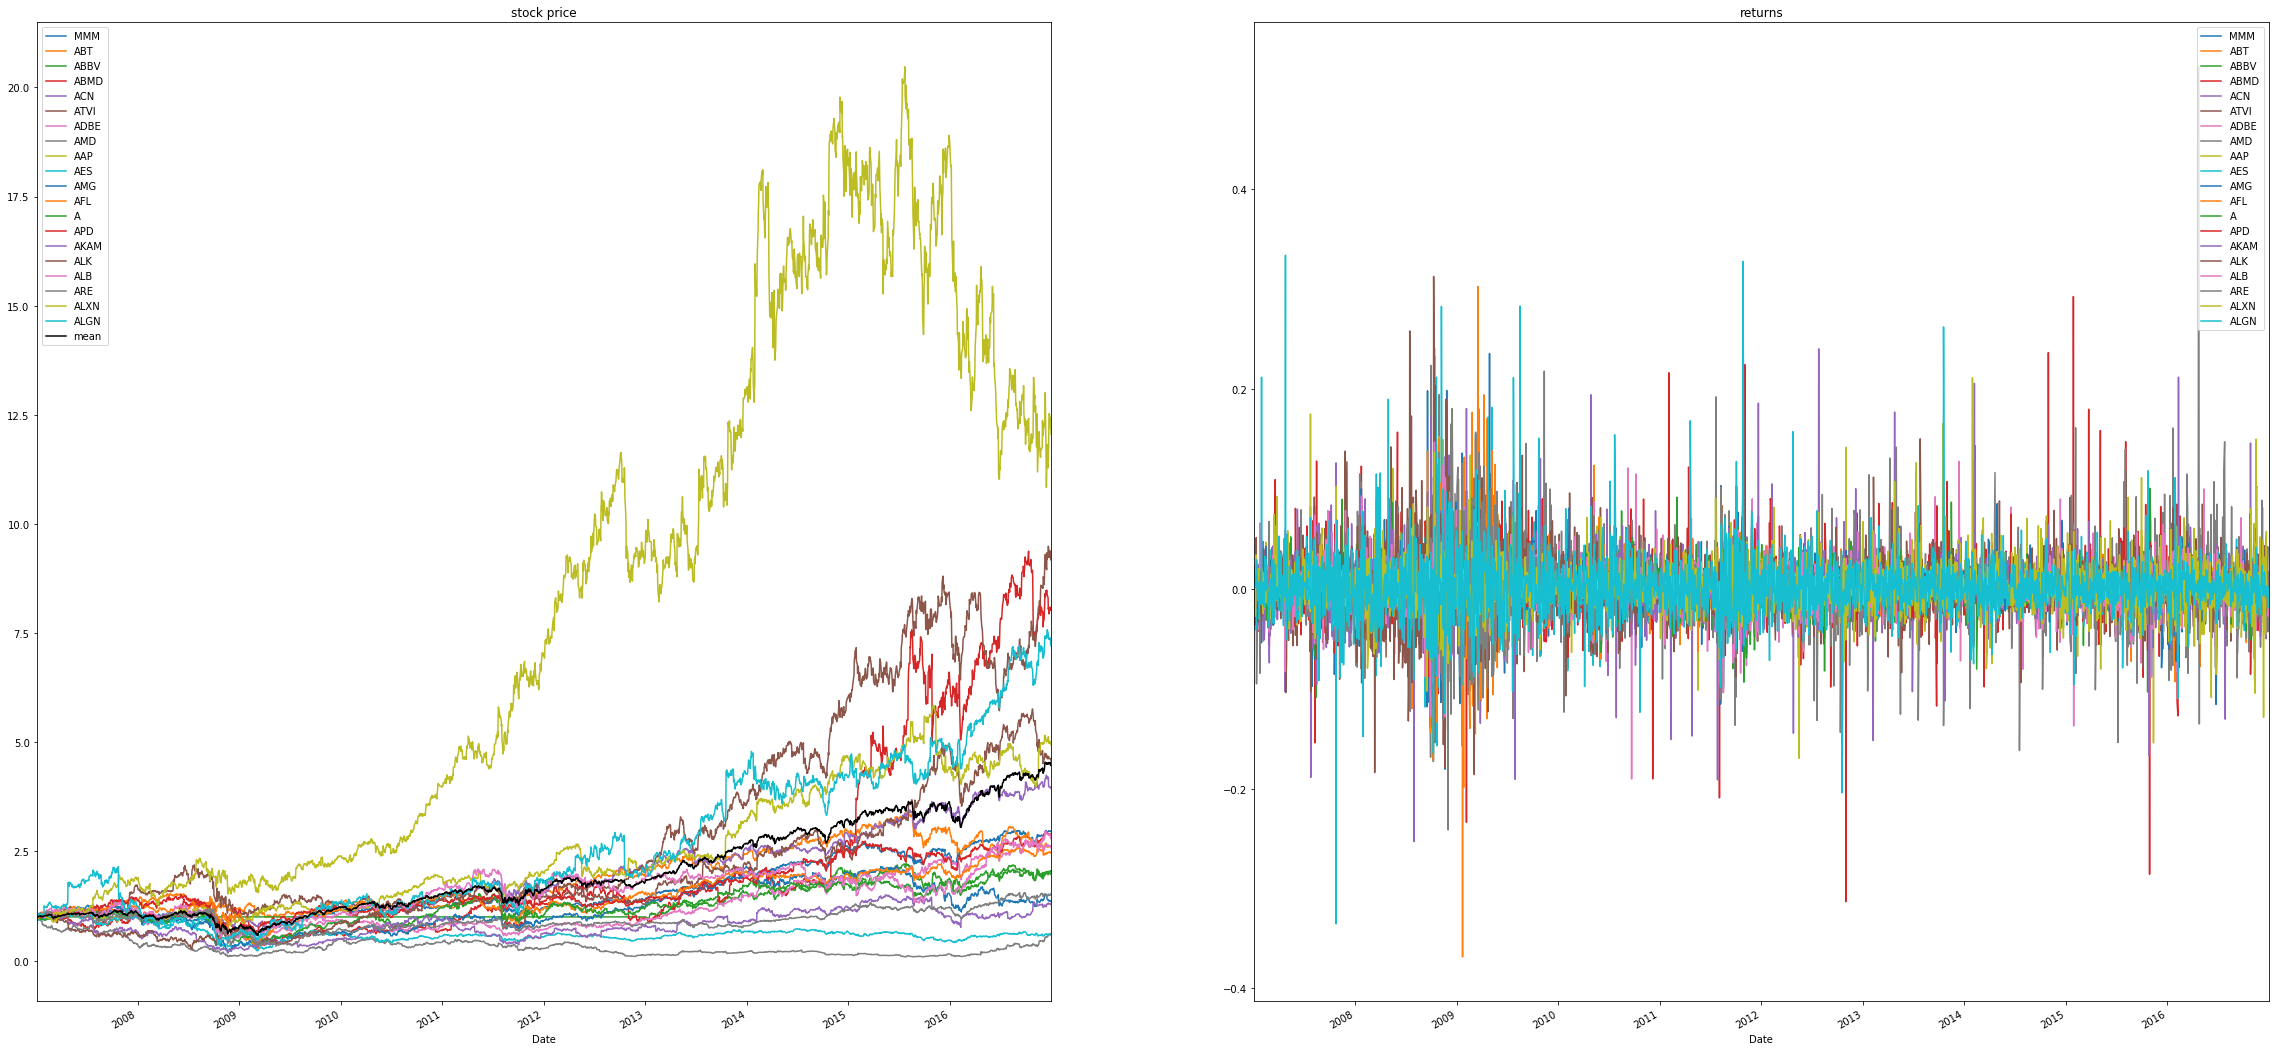

In [12]:
delete_nans('returns.csv', 'returns.csv')
plot_example_returns('returns.csv', N)

In [31]:
def convert(array):
    array = np.array(array)
    temp = array.argsort()
    print(temp)
    print(temp[:,-3:])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    print()
    return ranks
x = [[3,2,1,2,3,0],
     [1,2,3,4,5,6]]
convert(x)

[[5 2 1 3 0 4]
 [0 1 2 3 4 5]]
[[3 0 4]
 [3 4 5]]


ValueError: shape mismatch: value array of shape (2,) could not be broadcast to indexing result of shape (2,6,6)

In [48]:
def largest(array, amount):
    return array.argsort()[:,-amount:]


def compare_top(model, x_test, y_test):
    amount = 5
    mean_all = np.mean(y_test)
    y_pred = model.predict(x_test)
    top_index = largest(y_pred,amount)
    mean_mach = np.mean(y_test[top_index])
    return mean_mach-mean_all
compare_top(model, x_test, y_test)


0.0014392306301221625

## Calculations 

In [20]:
def cnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1, 100, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    #init
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=inp_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model.add(layers.Dropout(0.5))
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

In [47]:
def main(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    variant = 'vola'
    inp_shape=(dur,N)
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets_xxx(train, dur, variant) 
    x_test,y_test = get_data_subsets_xxx(test, dur,variant)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = cnn(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_test,y_test
    
model,x_test,y_test = main(returns, 100, 2000)

1900
518
x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
Epoch 1/100
1900/1900 [==============================] - 8s 4ms/step - loss: 2.8755e-04 - mean_squared_error: 2.8755e-04 - mean_absolute_error: 0.0102
Epoch 2/100
1900/1900 [==============================] - 2s 944us/step - loss: 2.5378e-04 - mean_squared_error: 2.5378e-04 - mean_absolute_error: 0.0097
Epoch 3/100
1900/1900 [==============================] - 2s 919us/step - loss: 2.3812e-04 - mean_squared_error: 2.3812e-04 - mean_absolute_error: 0.0094
Epoch 4/100
1900/1900 [==============================] - 1s 703us/step - loss: 2.3323e-04 - mean_squared_error: 2.3323e-04 - mean_absolute_error: 0.0095
Epoch 5/100
1900/1900 [==============================] - 1s 660us/step - loss: 2.2241e-04 - mean_squared_error: 2.2241e-04 - mean_absolute_error: 0.0093
Epoch 6/100
1900/1900 [==============================] - 1s 620us/step - loss: 2.1279e-04 - mean

1900/1900 [==============================] - 1s 629us/step - loss: 1.1966e-04 - mean_squared_error: 1.1966e-04 - mean_absolute_error: 0.0075
Epoch 54/100
1900/1900 [==============================] - 1s 582us/step - loss: 1.1761e-04 - mean_squared_error: 1.1761e-04 - mean_absolute_error: 0.0074
Epoch 55/100
1900/1900 [==============================] - 1s 567us/step - loss: 1.1777e-04 - mean_squared_error: 1.1777e-04 - mean_absolute_error: 0.0074
Epoch 56/100
1900/1900 [==============================] - 1s 561us/step - loss: 1.1697e-04 - mean_squared_error: 1.1697e-04 - mean_absolute_error: 0.0074
Epoch 57/100
1900/1900 [==============================] - 1s 562us/step - loss: 1.1770e-04 - mean_squared_error: 1.1770e-04 - mean_absolute_error: 0.0074
Epoch 58/100
1900/1900 [==============================] - 1s 588us/step - loss: 1.1707e-04 - mean_squared_error: 1.1707e-04 - mean_absolute_error: 0.0074
Epoch 59/100
1900/1900 [==============================] - 1s 564us/step - loss: 1.1490e-0

In [45]:
def get_data_subsets_xxx(df, dur, variant='next_day'):
    """ variant options: month, vola, next_day
    
    """
    df = np.array(df)
    month = 30
    leng = df.shape[0]
    x=[]
    y=[]
    for i in range(leng):
        if dur+i>=leng:
            print (i)
            break
        if variant == 'vola':
            x.append(np.abs(df[i:dur+i,:]))
            y.append(np.abs(df[dur+i,:]))
        else:
            x.append(df[i:dur+i,:])
            if variant == 'month':
                y.append(np.mean(df[dur+i:dur+i+month,:]))
            elif variant == 'next_day':
                y.append(df[dur+i,:])
            else:
                raise NameError("Use correct fun_label")
    return np.array(x),np.array(y)

def get_data_subsets_vola(df,dur):
    df = np.array(df)
    month = 30
    leng = df.shape[0]
    x=[]
    y=[]
    for i in range(leng):
        if dur+i>=leng:
            print (i)
            break
        x.append(np.abs(df[i:dur+i,:]))
        y.append(np.abs(df[dur+i,:]))
    return np.array(x),np.array(y)


def get_data_nextday(input_df):
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    return x_train, y_train, x_test, y_test

def get_data_nextmonth(input_df):
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets_month(train, dur) 
    x_test,y_test = get_data_subsets_month(test, dur)
    return x_train, y_train, x_test, y_test

def get_data_vola(input_df):
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets_vola(train, dur) 
    x_test,y_test = get_data_subsets_vola(test, dur)
    return x_train, y_train, x_test, y_test


Die Funktion get_data_subsets unterteilt die Matrix in eine Matrix der Dimension dur x N (Zeitfenster x Stocks) und korrespondierender Vektor für den Tag darauf (dur=1 x stocks). Jedes Matrix-Vektor Paar stellt einen Input plus Target Output(Label, Lösung) dar.

### Tests 

Function to check wether stock value changes were recognised to increase/decrease correctly

In [49]:
def directional_goodness(model,x_new,y_new):
    """
    directional goodnes gives the factor of correctly predicted signs of first order derivative of returns to false ones
    oder auch: 
    gibt die Anzahl der Beobachtungen an, deren Vorhersage das richtige Vorzeichen hatte (Kurs steigt, Kurs fällt)
    """
    y_pred = model.predict(x_new)
    count = 0
    #print(y_new.shape)
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] > 0
            n = y_new[i,j] > 0
            if n==p:
                count +=1
    print('percentage of correctly predicted directions of returns: ' + str(count/len(y_pred)/len(y_pred[0])))

In [57]:
def goodness(model,x_new,y_new):
    """
    directional goodnes gives the factor of correctly predicted signs of first order derivative of returns to false ones
    oder auch: 
    gibt die Anzahl der Beobachtungen an, deren Vorhersage das richtige Vorzeichen hatte (Kurs steigt, Kurs fällt)
    """
    y_pred = model.predict(x_new)
    count = 0
    #print(y_new.shape)
    
    for i in range(len(y_pred)):
        med = np.median(y_new[i])
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] - med > 0
            n = y_new[i,j] - med > 0
            if n==p:
                count +=1
    print('percentage of correctly predicted directions of returns: ' + str(count/len(y_pred)/len(y_pred[0])))

In [58]:
directional_goodness(model,x_test,y_test)

percentage of correctly predicted directions of returns: 0.9878378378378379


In [59]:
goodness(model,x_test,y_test)

percentage of correctly predicted directions of returns: 0.5214285714285715


Function to check internal goodness - predicted values vs actual measured values used for training

In [51]:
def internal_goodness(model, x_new, y_new):
    print('compare true to predicted values of internal validation on learned dataset: ')
    y_pred = model.predict(x_new)
    #model.predict nimmt x-werte und gibt die predicteten y-werte zurück
    plt.scatter(y_new, y_pred)

compare true to predicted values of internal validation on learned dataset: 


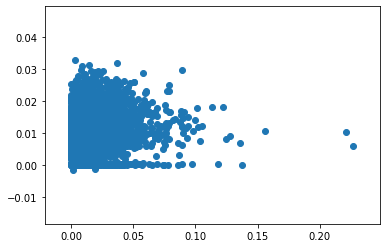

In [52]:
internal_goodness(model,x_test,y_test)

Function to check external goodness - predicted values for future data vs actual future data

In [55]:
def external_goodness(model, x_new, y_new):
    print('compare true to predicted values of external validation set: ')
    y_pred = model.predict(x_new)
    color =  ["r", "b", "g"]
    for i in range(3):
        plt.plot(y_new[i],c=color[i], label = 'true')
        plt.plot(y_pred[i], c=color[i], linestyle='--', label = 'pred')
    plt.legend()

compare true to predicted values of external validation set: 


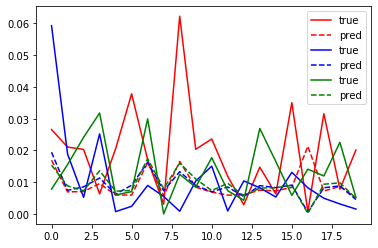

In [56]:
external_goodness(model,x_test,y_test)